In [333]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [334]:
class Simulator:
    
    def __init__(self, w, b, sigma, N, design_range=(-10,10)):
        self.w = w
        self.b = b
        self.theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        self.sigma = sigma
        self.N = N
        self.design_range = design_range
        self.X = None
        self.y = None
        self.y_mean = None
        
    def run(self):
        designs = np.random.uniform(self.design_range[0], self.design_range[1], size=(self.N, self.w.size))
        self.X = np.concatenate([designs, np.ones((self.N, 1))], axis=1)
        self.y_mean = (self.X @ self.theta).squeeze()
        self.y = np.random.multivariate_normal(mean=self.y_mean, cov=np.diag([self.sigma**2] * self.N))
    
    def plot(self):
        x = self.X[:, 0]
        plt.scatter(x, self.y, label="data")
        x_dense = np.linspace(self.design_range[0], self.design_range[1], 100)
        y_dense = x_dense * self.w[0] + self.b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(self.N))
        plt.show()

In [335]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(d + 1, 2)
        self.output_layer = nn.Linear(2, 1, bias=False)
    def forward(self, x):
        x = torch.sigmoid(self.layer_1(x))
        return self.output_layer(x)

In [336]:
# Helper function for collecting nn gradient into a vector
def collect_grads(model):
    return torch.cat([p.grad.data.view(1, -1) for p in model.parameters()], dim=-1)

# Helper function for computing sizes of all nn parameters
def get_param_sizes(model):
    return [p.reshape(-1).size()[0] for p in model.parameters()]

# Helper function for writing the updated weights
def update_params(new_params, model, param_sizes):
    start_index = 0
    for i, p in enumerate(model.parameters()):
        end_index = start_index + param_sizes[i]
        source_tensor = new_params[:, start_index:end_index].reshape(p.shape)
        p.data = source_tensor
        start_index = end_index
        
def collect_params(model):
    return torch.cat([p.data.view(1, -1) for p in model.parameters()], dim=-1)

def print_params(model):
    for p in model.parameters():
        print(p.data)

In [337]:
# True weight(s)
w = np.array([1.5, -1.0, 0.7])

# Input dimensionality
d = w.size

# True intercept
b = 0.5

# True standard deviation
sigma = 0.5

# Number of data points
N = 100

# Defines range of inputs x
design_range = (-1.0, 1.0)

# Simulate
simulator = Simulator(w, b, sigma, N, design_range)
simulator.run()

X = simulator.X
y = simulator.y

true_params = np.concatenate([[sigma], w, [b]], axis=0)

In [338]:
# Helper function for constructing potential energy function
def create_U(X, y, sigma_0):
    
    def U(nn, tau):
        fit = 0.5 * tau * ((y - nn(X)) ** 2).sum()
        params = collect_params(nn)
        l2 = (params ** 2).sum()
        reg = l2 / (2 * sigma_0 ** 2)
        return fit + reg
    
    return U

# Helper function for constructing gradient of potential energy function
def create_grad_U(X, y, sigma_0):
    
    def grad_U(nn, tau, U):
        PE = U(nn, tau)
        nn.zero_grad()
        PE.backward()
        grad = collect_grads(nn)
        return grad
    
    return grad_U


# Helper function for constructing conditional distribution for tau
def create_p_tau(X, y, alpha_0, beta_0, N):
    alpha = alpha_0 + N / 2
    
    def p_tau(tau, nn):
        z = y - nn(X)
        beta = (beta_0 + 0.5 * z.T @ z).detach().numpy().item()
        return np.random.gamma(alpha, 1 / beta)
    
    return p_tau

In [339]:
class ODESolver:
    
    def __init__(self, grad_U, epsilon, L, m, param_sizes):
        self.grad_U = grad_U
        self.epsilon = epsilon
        self.L = L
        self.m = m
        self.param_sizes = param_sizes
        
    def dq(self, p):
        return p / self.m
    
    def leapfrog(self, q, p, tau, nn):
        p = p - self.epsilon * self.grad_U(nn, tau, U) / 2
        for i in range(self.L):
            t1 = time.time()
            with torch.no_grad():
                q = q + self.epsilon * self.dq(p)
                update_params(q, nn, self.param_sizes)
            if i != self.L - 1:
                p = p - self.epsilon * self.grad_U(nn, tau, U)
        p = p - self.epsilon * self.grad_U(nn, tau, U) / 2
        p = -p
        return q, p

In [340]:
class HMC:
    
    def __init__(self, U, grad_U, p_tau, m, num_params, solver):
        self.U = U
        self.grad_U = grad_U
        self.p_tau = p_tau
        self.m = m
        self.num_params = num_params
        self.solver = solver
        self.samples = None
    
    def step(self, q, tau, model, param_sizes):
        
        p = np.random.multivariate_normal(np.zeros(self.num_params), np.diag([1] * self.num_params))
        
        p = torch.tensor(p, dtype=torch.float32, requires_grad=False)
        
        with torch.no_grad():
            U = self.U(model, tau)

        q_proposed, p_proposed = self.solver.leapfrog(q, p, tau, model)
        
        with torch.no_grad():
            
            K = ((p ** 2) / (2 * self.m)).sum()

            # Write proposed parameters into neural network
            update_params(q_proposed, model, param_sizes)

            # Evaluate potential energy with proposed parameters
            U_proposed = self.U(model, tau)

            K_proposed = ((p_proposed ** 2) / (2 * self.m)).sum()

            log_energy_ratio = (U - U_proposed + K - K_proposed).detach().numpy()

            u = np.random.uniform()
            if u < np.exp(log_energy_ratio):
                return q_proposed, 1
            else:
                return q, 0
    
    def run(self, model, param_sizes, theta, tau, num_samples=1000, burn_in=100):
        
        N = num_samples - burn_in
        self.samples = np.zeros((N, self.num_params + 1))
        acceptances = []
        
        for i in range(num_samples):
            theta, acceptance = self.step(theta, tau, model, param_sizes)
            
            with torch.no_grad():
                update_params(theta, model, param_sizes)
                tau = self.p_tau(tau, model)
            
            if i >= burn_in:
                j = i - burn_in
                self.samples[j, 0] = 1 / np.sqrt(tau)
                self.samples[j, 1:] = theta.detach().numpy()
                acceptances.append(acceptance)
        
        return self.samples, acceptances
    
    def plot(self, true_params):
        
        num_params = self.num_params
        plt.figure(figsize=(15, 5 * num_params))
        param_names = ["sigma"]
        
        for i in range(num_params - 2):
            param_names.append("weight " + str(i+1))
        param_names.append("intercept")
        
        for i in range(num_params):
            true_val = true_params[i]
            samples = self.samples[:, i]
            plt.subplot(num_params,2,i*2+1)
            y, _, _ = plt.hist(samples, bins=100, label="samples")
            max_y = int(np.max(y))
            plt.plot([true_val] * max_y, range(max_y), c="r", label="true value")
            plt.title("Histogram for {}".format(param_names[i]))
            plt.legend()
            plt.subplot(num_params,2,i*2+2)
            plt.plot(samples, label="chain")
            plt.plot([0, samples.size], [true_val, true_val], c="r", label="true value")
            plt.title("Trace plot for {}".format(param_names[i]))
            plt.legend()
            
        plt.show()

    def evaluate(self, test_simulator):
        
        "Computes MSE between test data and the predictions of the model"
        
        test_covariates = test_simulator.X
        mean_weights = self.samples.mean(axis=0)[1:]
        predictions = test_covariates @ mean_weights
        mse = ((predictions - test_simulator.y) ** 2).mean()
        return mse

In [341]:
# Define priors
sigma_0 = 1.0
alpha_0 = 0.001
beta_0 = 0.001

# Create helper functions
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(-1, 1)
U = create_U(X_tensor, y_tensor, sigma_0=sigma_0)
grad_U = create_grad_U(X_tensor, y_tensor, sigma_0=sigma_0)
p_tau = create_p_tau(X_tensor, y_tensor, alpha_0, beta_0, N)

mlp = MLP()
param_sizes = get_param_sizes(mlp)
num_params = sum(param_sizes)

# Define HMC parameters

# Step size
epsilon = 0.01

# Number of steps in the proposal
L = 20

# Mass parameter
m = 1.0

solver = ODESolver(grad_U, epsilon, L, m, param_sizes)

chain = HMC(U, grad_U, p_tau, m, num_params, solver)

# Initialize chain
theta = collect_params(mlp)
tau = 1.0

# Run chain
samples, acceptances = chain.run(mlp, param_sizes, theta, tau, num_samples=4000, burn_in=1000)

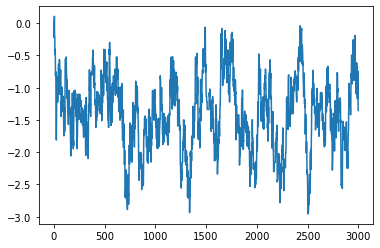

In [352]:
plt.plot(samples[:, 5])
plt.show()

In [342]:
mean_weights = samples[:, 1:].mean(axis=0).reshape(1, -1)
mean_weights_tensor = torch.tensor(mean_weights, dtype=torch.float32)
update_params(mean_weights_tensor, mlp, param_sizes)
y_pred = mlp(X_tensor)
mse = ((y_pred - y_tensor) ** 2).mean()
mse

tensor(0.2031, grad_fn=<MeanBackward0>)

In [343]:
mse2 = ((y_pred.T - torch.tensor(simulator.y_mean).T) ** 2).mean()
mse2

tensor(0.0233, dtype=torch.float64, grad_fn=<MeanBackward0>)

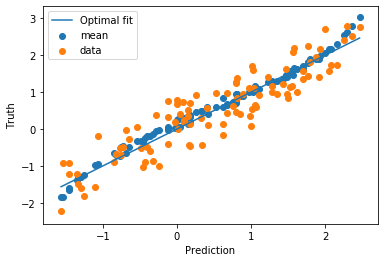

In [344]:
y_pred = y_pred.detach().numpy()
plt.scatter(y_pred, simulator.y_mean, label="mean")
plt.scatter(y_pred, y, label="data")
grid = np.linspace(np.min(y_pred), np.max(y_pred), 100)
plt.plot(grid, grid, label="Optimal fit")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
plt.show()

In [124]:
np.random.gamma(5,1/5)

0.5133407495177593